# Size and Value Portfolio

In this project, we are concerned with replicating the ME-sorted deciles (Market Equity), BM-sorted deciles (Book to Market), High Minus Low (HML) and Small Minus Big (SMB) factors. These portfolios are described in depth in French and Fama's 1992 paper "The Cross-Section of Expected Stock Returns" and their 1993 paper "Common Risk Factors in the Returns on Stocks and Bonds". This replication uses CRSP Raw, CRSP Delisted, CRSP CSTAT data and CRSP Datalink, and CRSP Pension data. We need all of these dataframes to download stock data and the corresponding accounting data. 

The risk free rate is from the French Fama numbers (not CRSP) which we download below, per the directions. We will combine the 'dlret' and 'ret' columns for the stocks and redefine 'ret' to encompass all returns for these stocks. We will filter our stocks to only use the 10 and 11 sharecodes and the 1, 2 and 3 exchanges, per the French Fama website. Both the ME and BE portfolios are divided based on the NYSE stocks, meaning each decile has an equal amount of NYSE stocks. We do this so the large cap stocks (which tend to be in the NYSE) do not generally favor one specific decile. This is especially important for the ME decile replicaiton. Our returns are shown as excess returns.

We use all non financial firms in the intersection of (a) the NYSE, AMEX, and NASDAQ return files from the Center for Research in Security Prices (CRSP) and (b) the merged COMPUSTAT annual industrial files of income-statement and balance-sheet data, also maintained by CRSP. Furthermore, we exclude financial firms because the high leverage that is normal for these firms probably does not have the same meaning as for nonfinancial firms, where high leverage more likely indicates distress. These are all requirements from the French Fama papers.

To ensure that the accounting variables are known before the returns they are used to explain, we match the accounting data for all fiscal year ends in calendar year with the returns for July of year $t$ to June of year $t+1$. The 6-month (minimum) gap between fiscal year end and the return tests is conservative and used to ensure that this information would be available at the time of portfolio replication at the end of June each year.

We use a firm's market equity at the end of December of year $t-1$ to compute its book-to-market, leverage, and earnings-price ratios for year $t-1$, and we use its market equity for June of year t to measure its size. Thus, to be included in the return tests for July of year $t$, a firm must have a CRSP stock price for December of year $t-1$ and June of year t. 

The final output is between January 1973 and December 2023.

Below is a list of the libraries I used for this project.

In [4]:
import wrds
import pandas as pd
import pandas_datareader
from pandas.tseries.offsets import *
import datetime
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import os
import statistics

Below I connected the script to the “WRDS” servers so I could access the data for the stocks.

In [5]:
id = 'johncrowe'

## Compustat (data from wrds)

conn = wrds.Connection(id)

# Get cstat accounting data
a = conn.raw_sql("""
                    select a.gvkey, a.datadate, a.at, a.pstkl, a.txditc, a.fyear, a.ceq, a.lt, 
                    a.mib, a.itcb, a.txdb, a.pstkrv, a.seq, a.pstk, b.sic, b.year1, b.naics
                    from comp.funda as a
                    left join comp.names as b
                    on a.gvkey = b.gvkey
                    where indfmt='INDL'
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    """)

# Get additional Pension data
b = conn.raw_sql("""
                    select gvkey, datadate, prba
                    from comp.aco_pnfnda
                    where indfmt='INDL'
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    """)

# Get link table data
c = conn.raw_sql("""
                    select gvkey, lpermno as permno, lpermco as permco, linktype, linkprim, liid,
                    linkdt, linkenddt
                    from crspq.ccmxpf_linktable
                    where substr(linktype,1,1)='L'
                    and (linkprim ='C' or linkprim='P')
                    """)

# Get CRSP stock data
d = conn.raw_sql("""
                    select a.permno, a.permco, a.date, b.exchcd, b.siccd, b.naics,
                    a.ret, a.retx, a.shrout, a.prc
                    from crspq.msf as a
                    left join crspq.msenames as b
                    on a.permno=b.permno
                    and b.namedt<=a.date
                    and a.date<=b.nameendt
                    where b.shrcd in (10,11)
                    and b.exchcd in (1,2,3)
                    """)

# Get delisted returns
e = conn.raw_sql("""
                    select a.permno, a.permco, a.dlret, a.dlretx, a.dlstdt, 
                    b.exchcd as dlexchcd, b.siccd as dlsiccd, b.naics as dlnaics
                    from crspq.msedelist as a
                    left join crspq.msenames as b
                    on a.permno=b.permno
                    and b.namedt<=a.dlstdt
                    and a.dlstdt<=b.nameendt
                    where b.shrcd in (10,11)
                    and b.exchcd in (1,2,3)
                    """) 

# Close connection
conn.close()

Enter your WRDS username [John]:johncrowe
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Below we set our a, b, c, d and e variables to our final raw variables. We do this so we do not have to reconnect to the server everytime we want to re-run our code, which helps when we are optimizing. 

In [101]:
cstat = a.copy()
Pension = b.copy()
crsp_cstat = c.copy()
crsp_raw = d.copy()
dlret_raw = e.copy()

The below code imports our French Fama factors. The BM factors are for the book for market decile portfolios and the ME factors for the market equity decile portfolios. I use this to find the correlation with the replication in parts 2 and 3. I also use the French Fama for the risk free rate to determine the excess returns. Lastly, I use the French Fama HML and SMB returns to determine the correlation with our replication. I found the warnings to not have any impact on the data extract.

In [102]:
# Fama and French 3 Factors
data2 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',start='1900', end=str(datetime.datetime.now().year+1))
french = data2.read()[0] / 100 # Monthly data
french['Mkt'] = french['Mkt-RF'] + french['RF']

# Book-to-Market Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_BE-ME',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']] / 100
data2.columns = 'BM01','BM02','BM03','BM04','BM05','BM06','BM07','BM08','BM09','BM10'
french = pd.merge(french,data2,how='left',on=['Date'])

# Size Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_ME',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']] / 100
data2.columns = 'ME01','ME02','ME03','ME04','ME05','ME06','ME07','ME08','ME09','ME10'
french = pd.merge(french,data2,how='left',on=['Date'])

# 25 Book-to-Market and Size Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('25_Portfolios_5x5',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0].rename(columns={"SMALL LoBM":"ME1 BM1","SMALL HiBM":"ME1 BM5","BIG LoBM":"ME5 BM1","BIG HiBM":"ME5 BM5"}) / 100
french = pd.merge(french,data2,how='left',on=['Date'])

# Changing date format and save
french = french.reset_index().rename(columns={"Date":"date"})
french['date'] = pd.DataFrame(french[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)

french['Year'] = french['date'].dt.year
french['Month'] = french['date'].dt.month

C:\Users\John\AppData\Local\Temp\ipykernel_12808\3740889511.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  french = data2.read()[0] / 100 # Monthly data
C:\Users\John\AppData\Local\Temp\ipykernel_12808\3740889511.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  french = data2.read()[0] / 100 # Monthly data
C:\Users\John\AppData\Local\Temp\ipykernel_12808\3740889511.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', '

C:\Users\John\AppData\Local\Temp\ipykernel_12808\3740889511.py:20: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data2 = data2.read()[0].rename(columns={"SMALL LoBM":"ME1 BM1","SMALL HiBM":"ME1 BM5","BIG LoBM":"ME5 BM1","BIG HiBM":"ME5 BM5"}) / 100
C:\Users\John\AppData\Local\Temp\ipykernel_12808\3740889511.py:20: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data2 = data2.read()[0].rename(columns={"SMALL LoBM":"ME1 BM1","SMALL HiBM":"ME1 BM5","BIG LoBM":"ME5 BM1","BIG HiBM":"ME5 BM5"}) / 100


Below we are cleaning the crsp_cstat dataframe, putting it into a useable format, and renaming it as LinkTable. This is an important dataframe for connecting our accounting data with our stock data. The main use of the crsp_cstat is connecting each gvkey with each permno. Hopefully each permno will have a best fit gvkey, at least during a certain period of time. We go over below how to further filter the Linktable to get rid of duplicates and make sure the gvkey is fit for valid time frames. Also note that several permno can have the same permco, so we want to remove any permno-Year-Month duplicates.

In [103]:
# Clean link table data and put into usable format    
crsp_cstat[['gvkey', 'permno', 'permco']] = crsp_cstat[['gvkey', 'permno', 'permco']].astype('int32')
crsp_cstat['linkdt'] = pd.to_datetime(crsp_cstat['linkdt'], format='%Y-%m-%d')
crsp_cstat['linkenddt'] = pd.to_datetime(crsp_cstat['linkenddt'], format='%Y-%m-%d')
LinkTable = crsp_cstat.copy()

In the code below, we merge our linktable data with the stock data. Each month-year-stock should have an associated gvkey, permno and permco. As we went over earlier, we should have unique combinations for each permno-month-year combination. I put the crsp raw data into a useable format and merged with the delisted returns raw to find the complete returns, just as we have done in previous projects. I merged these two dataframes to form the crsp dataframe, which has all of our standard stock information including share price, shares outstanding, etc. Per the standard procedure, we replace the NAs in our returns with zeros so we can preserve our stock data.

The next step is to attach the month-lagged market cap for each stock-year-month to help us with later calculations. This involves sorting stocks by permno-date, grouping all stocks by permno and then shifting the newly formed market equity column by one. An alternative option would be to create a new dataframe, calculate the market equity, shift the dates and merge with the original.

In [104]:
# Clean crsp_raw data and put into useable format
crsp_raw = crsp_raw.sort_values(['permno', 'date']).reset_index(drop=True).copy()
crsp_raw[['permno', 'permco']] = crsp_raw[['permno', 'permco']].astype('int32')
crsp_raw['date'] = pd.to_datetime(crsp_raw['date'], format='%Y-%m-%d') + MonthEnd(0)

# Clean delisted return data and put into useable format
dlret_raw = dlret_raw.sort_values(['permno', 'dlstdt']).reset_index(drop=True).copy()
dlret_raw.permno = dlret_raw.permno.astype('int32')
dlret_raw['dlstdt'] = pd.to_datetime(dlret_raw['dlstdt'], format='%Y-%m-%d')
dlret_raw['date'] = dlret_raw['dlstdt'] + MonthEnd(0)

# Merging crsp with delisting return
crsp = pd.merge(crsp_raw, dlret_raw, how='left', on=['permno', 'permco', 'date'])

# Compute returns including delisting returns
aux = crsp[(crsp['ret'].isna() & crsp['dlret'].isna())].index
crsp['dlret'] = crsp['dlret'].fillna(0)
crsp['ret'] = crsp['ret'].fillna(0)
crsp['ret'] = (1+crsp['ret']) * (1+crsp['dlret']) - 1
crsp.loc[aux,['ret']] = np.nan

# Market Equity (Market Capitalization)
crsp['me'] = crsp['prc'].abs()*crsp['shrout']  # calculate market equity

# Lagged Market Equity (to be used as weights)
crsp = crsp.sort_values(by=['permno', 'date']).reset_index().drop('index',axis=1).copy()
crsp['daten'] = crsp['date'].dt.year*12 + crsp['date'].dt.month
crsp['IsValidLag'] = crsp['daten'].diff(1) == 1 # Lag date has to be the lagged date
crsp.loc[crsp[crsp['permno'].diff(1) != 0].index,['IsValidLag']] = False # Lagged date has to be the same security
crsp['Lme'] = crsp[['permno','me']].groupby('permno').shift(1)
crsp.loc[crsp[crsp['IsValidLag'] == False].index,['Lme']] = np.nan
crsp = crsp.drop(['IsValidLag', 'daten'], axis=1)

# Substituing missing returns with zero (no trade assumption)
crsp.loc[crsp['ret'].isna(),'ret'] = 0

# Sorting by date and permno
crsp = crsp.sort_values(by=['date', 'permno']).reset_index().drop('index',axis=1).copy()
crsp[['exchcd', 'siccd']] = crsp[['exchcd', 'siccd']].astype(float)

# Take specific columns we need for crsp
crsp = crsp[['permno', 'permco', 'date', 'exchcd', 'siccd', 'naics', 'ret', 'retx', 'shrout', 'prc', 'dlret', 'dlretx', 'Lme']].copy() # comment this line if you want to keep other crsp variables

We now have all of our cleaned stock data. Our next step is to merge this with our LinkTable. LinkTable primarily lnks each permno with a valid gvkey. It also includes dates that each gvkey-permno combination is valid. The first step is merging our crsp data with our LinkTable into a new dataframe, crsp_linktable. After this merge, we have a dataframe with permno, permco and gvkey. We want unique combinations of permno and date. Upon checking, we find there to be 995,053 permno-date duplicates. 

In step 2, we restrict our gvkeys to only correspond to valid dates. As mentioned earlier, each gvkey comes with a start and end date. If the end date is NA, that means the gvkey is still active. We can then filter our stock-year-month to only include stocks with a valid gvkey. This takes us down to 6,670 duplicates.

In step 3, we only keep linktypes with type 'LC'. We do this because it means the link has been validated by CRSP. This brings us down to 45 duplicates.

In step 4, we only keep the links labeled as 'primary' link. This leaves us with zero duplicates.

I then drop all of the columns we do not need and create a Port_Year column. This is the year each stock-year-month would have been constructed, in accordance with French Fama. Since stocks are made at the end of June, this means all stock returns from January to June correspond to a Port_Year of the previous year. All stock returns from July to December correspond to a Port_Year of that year. I then reformat this into the desired format and only keep the columns we need moving forward.

In [105]:

# Step 1: merge all links
crsp = crsp.sort_values(['permco','permno','date']).reset_index(drop=True).copy()
crsp_linktable = crsp.merge(LinkTable, on=['permno','permco'], how='inner')

numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('Step 1: Number of Link Duplicates after merging: ' + str(numdup))

# Step 2: restrict to valid links
crsp_linktable = crsp_linktable[(crsp_linktable['linkdt'].isna() | (crsp_linktable['date'] >= crsp_linktable['linkdt'])) & (crsp_linktable['linkenddt'].isna() | (crsp_linktable['date'] <= crsp_linktable['linkenddt']))].copy()
crsp_linktable = crsp_linktable.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 2 (valid links): Number of Link Duplicates: ' + str(numdup))

# Step 3: if LC not LC linktype, only keep LC (LC stands for "Link research complete. Standard connection between databases.")
crsp_linktable['keep'] = True
crsp_linktable['flag'] = np.where(crsp_linktable['linktype'] == 'LC', 1, 0)  # Link research complete. Standard connection between databases.
crsp_linktable = crsp_linktable.merge(crsp_linktable[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index().rename(columns={'flag': 'ct_flag'}),on=['permno', 'date'], how='left')
crsp_linktable.loc[crsp_linktable[['permno', 'date']].duplicated(keep=False) & (crsp_linktable['ct_flag'] >= 1) & (crsp_linktable['flag'] == 0), 'keep'] = False
crsp_linktable = crsp_linktable[crsp_linktable['keep']].copy()
crsp_linktable.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 3 (keep linktype=LC): Number of Link Duplicates: ' + str(numdup))

# Step 4: if P and not P linkprim, only keep P
crsp_linktable['keep'] = True
crsp_linktable['flag'] = np.where((crsp_linktable['linkprim'] == 'P'), 1, 0)  # Primary Link Marker: "P" indicates a primary link marker, as identified by Compustat in monthly security data.
crsp_linktable = crsp_linktable.merge(crsp_linktable[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index().rename(columns={'flag': 'ct_flag'}),on=['permno', 'date'], how='left')
crsp_linktable.loc[crsp_linktable[['permno', 'date']].duplicated(keep=False) & (crsp_linktable['ct_flag'] >= 1) & (crsp_linktable['flag'] == 0), 'keep'] = False
crsp_linktable = crsp_linktable[crsp_linktable['keep']].copy()
crsp_linktable.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 4 (keep keeep linkprim=P): Number of Link Duplicates: ' + str(numdup))

# Dropping linktable variable that are no longer needed
crsp_linktable.drop(axis=1,columns=['linktype','linkprim','liid','linkdt','linkenddt'], inplace=True)

# Create Port_Year column to aid with our merge for the accounting dataframe
crsp_linktable['Port_Year'] = crsp_linktable['date'].apply(lambda x: x.year if x.month >= 7 else x.year - 1)
crsp_linktable['Port_Year'] = crsp_linktable['Port_Year'].astype('int32')

# Reorder dataframe into desired format
crsp_linktable = crsp_linktable[['date', 'permco', 'permno', 'gvkey', 'exchcd', 'siccd', 'ret', 'shrout', 'prc', 'Lme', 'Port_Year']]

Step 1: Number of Link Duplicates after merging: 995053
After Step 2 (valid links): Number of Link Duplicates: 6670
After Step 3 (keep linktype=LC): Number of Link Duplicates: 45
After Step 4 (keep keeep linkprim=P): Number of Link Duplicates: 0


We can see the format of our crsp_linktable below, which has our stock data and gvkey information.

In [106]:
crsp_linktable

,date,permco,permno,gvkey,exchcd,siccd,ret,shrout,prc,Lme,Port_Year
0,1986-01-31,7952,10000,13007,3.0,3990.0,0.000000,3680.0,-4.37500,NaN,1985
1,1986-02-28,7952,10000,13007,3.0,3990.0,-0.257143,3680.0,-3.25000,1.610000e+04,1985
2,1986-03-31,7952,10000,13007,3.0,3990.0,0.365385,3680.0,-4.43750,1.196000e+04,1985
3,1986-04-30,7952,10000,13007,3.0,3990.0,-0.098592,3793.0,-4.00000,1.633000e+04,1985
4,1986-05-31,7952,10000,13007,3.0,3990.0,-0.222656,3793.0,-3.10938,1.517200e+04,1985
...,...,...,...,...,...,...,...,...,...,...,...
3250720,2023-11-30,53453,93436,184996,3.0,9999.0,0.195379,3178921.0,240.08000,6.384545e+08,2023
3250721,2023-12-31,53453,93436,184996,3.0,9999.0,0.034988,3185000.0,248.48000,7.631954e+08,2023
3250722,2024-01-31,53453,93436,184996,3.0,9999.0,-0.246257,3184790.0,187.28999,7.914088e+08,2023
3250723,2024-02-29,53453,93436,184996,3.0,9999.0,0.077901,3184790.0,201.88000,5.964793e+08,2023


So far, we have mainly focused on stock return data. We now want to shift our focus to the accounting data. The primary information we need from the accounting data is the book equity for each stock, the portfolio construction year and the corresponding gvkey. Since our stock returns now have the best gvkey-permno combination, we can link each book equity to each permno-year-month. 

In the below code, we merge Pension and cstat to comprise all our necessary accounting information into the dataframe all_accounting. It is annual data, so we will merge on the datadate and gvkey columns. I also convert the columns into useable formats before our merge.

In [107]:
# Ensure 'gvkey' is integer type to help with our merge
Pension['gvkey'] = Pension['gvkey'].astype('int32')
cstat['gvkey'] = cstat['gvkey'].astype('int32')

# Convert datadate for Pension and cstat to datetime format
Pension['datadate'] = pd.to_datetime(Pension['datadate'], format='%Y-%m-%d')
cstat['datadate'] = pd.to_datetime(cstat['datadate'], format='%Y-%m-%d')

# Merge the cstat and Pension DataFrames on 'gvkey' and 'datadate'
all_accounting = cstat.merge(Pension, on=['gvkey', 'datadate'], how='left')

Next we want to use our accounting information to find the book value for each given portfolio construction year. Below we execute those equations and form the 'be' column. These equations are all provided on the hint section of the problem set. In most cases, there are NAs that keep us from computing the desired format. We then fill the NAs with backup equations. 

In addition to 'be', we also keep the 'gvkey', 'be', and the newly constructed 'Port_Year' columns. I constructed the 'Port_Year' column by adding 1 year to the datadate column. Since datadate signifies the fiscal year end of the dataframe, we are making the conservative assumption that the data will be released before 6 months. The book equity will therefore be between 6 months to 18 months old at the time of portfolio construction.

In [108]:
# Create shareholders equity using formula provided on problem set
all_accounting['she'] = all_accounting['seq']
all_accounting['she'] = all_accounting['she'].fillna(all_accounting['ceq'] + all_accounting['pstk'])
all_accounting['she'] = all_accounting['she'].fillna(all_accounting['at'] - all_accounting['lt'] - all_accounting['mib'])
all_accounting['she'] = all_accounting['she'].fillna(all_accounting['at'] - all_accounting['lt'])

# Create deferred taxes column using formula provided on problem set
all_accounting['dt'] = all_accounting['txditc']
all_accounting['dt'] = all_accounting['dt'].fillna(all_accounting['itcb'] + all_accounting['txdb'])
all_accounting['dt'] = all_accounting['dt'].fillna(all_accounting['itcb'])
all_accounting['dt'] = all_accounting['dt'].fillna(all_accounting['txdb'])

# Create preferred stock column using formula provided on problem set
all_accounting['ps'] = all_accounting['pstkrv']
all_accounting['ps'] = all_accounting['ps'].fillna(all_accounting['pstkl'])
all_accounting['ps'] = all_accounting['ps'].fillna(all_accounting['pstk'])

# Drop fill NAs with zero in columns for data that is not a strict requirement (data required for 'she')
all_accounting['ps'] = all_accounting['ps'].fillna(0)
all_accounting['dt'] = all_accounting['dt'].fillna(0)
all_accounting['prba'] = all_accounting['prba'].fillna(0)

# Create book equity value using formula provided on problem set, multiply by 1000 to get from millions to thousands
all_accounting['be'] = 1000*(all_accounting['she'] - all_accounting['ps'] + all_accounting['dt'] - all_accounting['prba'])

# Create final dataframe only including the columns we need
all_accounting = all_accounting[['datadate', 'gvkey', 'be']]

# Create Port_Year column so we can merge with out stock data
all_accounting['Port_Year'] = all_accounting['datadate'].dt.year.astype('int32') + 1

all_accounting

,datadate,gvkey,be,Port_Year
0,1961-12-31,1000,NaN,1962
1,1962-12-31,1000,552.0,1963
2,1963-12-31,1000,561.0,1964
3,1964-12-31,1000,627.0,1965
4,1965-12-31,1000,491.0,1966
...,...,...,...,...
572683,2021-12-31,355398,NaN,2022
572684,2022-12-31,355398,243417.0,2023
572685,2023-12-31,355398,271433.0,2024
572686,2022-12-31,356128,1778026.0,2023


The next step is to clean our accounting data. We want to see if we have any duplicates in our all_accounting data, so I ran the below code.

In [109]:
numdup1 = np.sum(all_accounting[['gvkey', 'datadate']].duplicated(keep='first'))
numdup2 = np.sum(all_accounting[['gvkey', 'Port_Year']].duplicated(keep='first'))

print(f'Number of gvkey-datadate duplicates: {numdup1}')
print(f'Number of gvkey-Port_Year duplicates: {numdup2}')

Number of gvkey-datadate duplicates: 0
Number of gvkey-Port_Year duplicates: 1324


We can see we have no gvkey-datadate duplicates but do have gvkey-Port_Year duplicates. This means some of the companies released more than one annual report in a given year. We want to therefore drop the first annual report in a given year since it will have less recent data. The below code sorts the accounting data, groups them together by gvkey and Port_Year, and then drops the first duplicate.

In [110]:
# Sort by 'gvkey', 'Port_Year', and 'dataddate' in descending order
all_accounting_sorted = all_accounting.sort_values(by=['gvkey', 'Port_Year', 'datadate'], ascending=[True, True, False])

# Drop duplicates, keeping the first occurrence (most recent 'datadate')
all_accounting_unique = all_accounting_sorted.drop_duplicates(subset=['gvkey', 'Port_Year'], keep='first')

# Reset index and set equal to all_accounting
all_accounting = all_accounting_unique.reset_index(drop=True).copy()

We can now verify our duplicates were removed.

In [111]:
numdup2 = np.sum(all_accounting[['gvkey', 'Port_Year']].duplicated(keep='first'))
print(f'Number of gvkey-Port_Year duplicates: {numdup2}')

Number of gvkey-Port_Year duplicates: 0


Now that our accounting information is correct, we want to merge this with our stock data to create a final useable dataframe. We can merge this on gvkey and portfolio construction year using a left merge to preserve our stock data.

The below code does several steps, so let's discuss them briefly. We first create 'Year' and 'Month' columns from our date column for readability. We then create a December and June market equity column for each stock-year-month row. We create the December equity for year $t-1$ and use it for the book to market equity for the portfolio construction at year t. This is because we assume the book equity information for year $t-1$ will be released by June of year $t$. Since the book equity corresponds to year $t-1$, it makes sense to use market equity corresponding to year $t-1$ as well. The ME portfolios are constructed at the end of June, so I use the market equity for June as French and Fama did. We will create this portfolio using the 'June_me' column. To better replicate, we found the sum of the entire permco by summing every permno present if they shared the same permco. This helped us to improve the replication slightly.

For the next step, I calculate book to market by dividing book equity by the newly created December equity column. This give us the book to market ratio of the previous fiscal year. 

I then drop all NAs, since we require a book to market value to construct our portfolios. 

Next, we exclude financial firms because the high leverage that is normal for these firms probably does not have the same meaning as for non financial firms, where high leverage more likely indicates distress. We can therefore exclude all firms with and siccd code between the values 6000 and 6999 as done in the cell below. We also filter for stocks from 1973 to 2024. We do this because the accounting data is not consistently available before this time.

Lastly, we exclude stocks with a negative book to market ratio, as directed by French and Fama, because a negative book to market is considered non-sensical and has no meaningful interpretation. 

Please note that French and Fama required all stocks to have monthly returns for at least 24 of the 60 preceding months. We did not make this a requirement because it has a small effect on overall replication.

In [112]:
# Merge accounting data with crsp stock data, using left merge to preserve our stock data
stocks = crsp_linktable.merge(all_accounting, on=['gvkey','Port_Year'], how='left')

# Create Year and Month columns
stocks['Year'] = stocks['date'].dt.year
stocks['Month'] = stocks['date'].dt.month

# Create December Equity column
dec_me = stocks[stocks['Month'] == 12].copy()

# Calculate the market equity (me)
dec_me['me'] = dec_me['prc'].abs() * dec_me['shrout']

# Group by 'permco', 'date', 'month' and sum 'me'
dec_me = dec_me.groupby(['permco', 'Year', 'Month', 'Port_Year'])['me'].sum().reset_index().copy()

# Rename the 'me' column to 'december_me'
dec_me = dec_me.rename(columns={'me': 'December_me'})

# Create Port_Year column for dec_me to help with our merge
dec_me['Port_Year'] = dec_me['Port_Year'].astype('int32') + 1

# Use only the columns we need, merge on permno and Port_Year
dec_me = dec_me[['Port_Year', 'permco', 'December_me']]

# Merge stocks with dec_me to attach December_me data to our stock data
stocks = stocks.merge(dec_me, on = ['permco', 'Port_Year'], how = 'left')

# Create June Equity column
june_me = stocks[stocks['Month'] == 6].copy()

# Calculate the market equity (me)
june_me['me'] = june_me['prc'].abs() * june_me['shrout']

# Group by 'permco', 'date', 'month' and sum 'me'
june_me = june_me.groupby(['permco', 'Year', 'Month', 'Port_Year'])['me'].sum().reset_index().copy()

# Rename the 'me' column to 'december_me'
june_me = june_me.rename(columns={'me': 'June_me'})

# Create Port_Year column for dec_me to help with our merge
june_me['Port_Year'] = june_me['Port_Year'].astype('int32') + 1

# Use only the columns we need, merge on permno and Port_Year
june_me = june_me[['Port_Year', 'permco', 'June_me']]

# Merge stocks with dec_me to attach December_me data to our stock data
stocks = stocks.merge(june_me, on = ['permco', 'Port_Year'], how = 'left')

# Create BtM_ratio column with our newly created book equity and December equity columns
stocks['BtM_ratio'] = stocks['be']/stocks['December_me']

# Drop all NAs in our rows since this data is essential for our portfolio construction
stocks = stocks.dropna(subset=['BtM_ratio', 'June_me'])

# Filter for non-financial institution stocks
stocks = stocks[(stocks['siccd'] < 6000) | (stocks['siccd'] > 6999)].copy()

# Filter to only include stocks from January 1968 to December 2024
stocks = stocks[(stocks['Year'] >= 1973) & (stocks['Year'] < 2024)].copy()

# Drop stocks with negative Book to Market ratio
stocks = stocks[stocks['BtM_ratio'] > 0].copy()

# Rearrange stocks into desired format and drop unwanted columns
stocks = stocks[['Year', 'Month', 'permno', 'permco', 'gvkey', 'exchcd', 'ret', 'prc', 'shrout', 'Lme', 'December_me', 'June_me', 'BtM_ratio']].copy()

The next step is to confirm we do not have any permno-Year-Month or gvkey-Year-Month duplicates.

In [113]:
numdup1 = np.sum(stocks[['permno', 'Year', 'Month']].duplicated(keep='first'))
numdup2 = np.sum(stocks[['gvkey', 'Year', 'Month']].duplicated(keep='first'))

print(f'Number of permno-Year-Month duplicates: {numdup1}')
print(f'Number of gvkey-Year-Month duplicates: {numdup2}')

Number of permno-Year-Month duplicates: 0
Number of gvkey-Year-Month duplicates: 0


We now have our completed stock dataframe that we can use to create our portfolios. The below code iterates through all of our stocks and assigns both an ME decile and a BM decile to each stock. Similar to previous projects, we create a dataframe of stocks present in a specific month. We then rank the stocks by their book to market and their June market equity. We then further filter to only include stocks present in the NYSE. From there, we break those stocks into 10 equal size quartiles, which gives us our bounds for the ME and BM deciles. We then assign all of the stocks for that time period an ME and BM decile and then add the results to our stocks_deciles dataframe, which is in the stock-year-month format. 

In [114]:
   
# Create final_df to store all of our values from each month and year
stocks_deciles = pd.DataFrame()
    
# Run a nested for loop through each unique year and month
for index_y, year in enumerate(sorted(stocks['Year'].unique())):
    for index_m, month in enumerate(sorted(stocks['Month'].unique())):

        # Create dataframe of all stocks for this specific month and date
        all_stocks = stocks[(stocks['Year'] == year) & (stocks['Month'] == month)].copy()
        all_stocks['BtM_Ranking_Ret'] = all_stocks['BtM_ratio'].rank(ascending=True)
        all_stocks['ME_Ranking_Ret'] = all_stocks['June_me'].rank(ascending=True)
        
        # Create dataframe of all NYSE stocks for this specific month and date
        nyse = all_stocks[(all_stocks['Year'] == year) & (all_stocks['Month'] == month) & (all_stocks['exchcd'] == 1)].copy()

        # Sort rankings from least to greatest
        nyse = nyse.sort_values(by='BtM_Ranking_Ret').copy()

        # Divide Rankings into 10 even deciles
        nyse['BtM_Quartile'] = pd.qcut(nyse['BtM_Ranking_Ret'], q=10, labels=False)
        quartile_ranges_1 = nyse.groupby('BtM_Quartile')['BtM_Ranking_Ret'].agg(['min', 'max'])

        # Increase max index so we do not leave any stocks behind
        quartile_ranges_1.iloc[9, 1] = np.inf
        quartile_ranges_1 += 1
        stock_bins_1 = [0] + quartile_ranges_1['max'].tolist()

        # Map ranges to all stocks giving us the BtM_decile
        all_stocks['BtM_decile'] = pd.cut(all_stocks['BtM_Ranking_Ret'], bins=stock_bins_1, labels=range(0, 10), include_lowest=True)
        
        # Add one to the deciles to match the standard format
        all_stocks['BtM_decile'] = all_stocks['BtM_decile'].astype(int) + 1

        # Sort rankings from least to greatest
        nyse = nyse.sort_values(by='ME_Ranking_Ret').copy()

        # Divide Rankings into 10 even deciles
        nyse['ME_Quartile'] = pd.qcut(nyse['ME_Ranking_Ret'], q=10, labels=False)
        quartile_ranges_2 = nyse.groupby('ME_Quartile')['ME_Ranking_Ret'].agg(['min', 'max'])

        # Increase max index so we do not leave any stocks behind
        quartile_ranges_2.iloc[9, 1] = np.inf
        quartile_ranges_2 += 1
        stock_bins_2 = [0] + quartile_ranges_2['max'].tolist()

        # Map ranges to all stocks giving us the BtM_decile
        all_stocks['ME_decile'] = pd.cut(all_stocks['ME_Ranking_Ret'], bins=stock_bins_2, labels=range(0, 10), include_lowest=True)
      
        # Add one to the deciles to match the standard format
        all_stocks['ME_decile'] = all_stocks['ME_decile'].astype(int) + 1
           
        stocks_deciles = pd.concat([stocks_deciles, all_stocks])


The next step is to create a HML and SMB classifications. This is well defined on the French Fama website, but we will mention it here as well. First some terms to define:

Small Value (SV) is the bottom 50\% of equity and top 70\% of BtM. 

Big Value (BV) is the top 50\% of equity and top 70\% of BtM. 

Small Neutral (SN) is the bottom 50\% of equity and 30\%-70\% BtM. 

Big Neutral (BN) is the top 50\% of equity and 30\%-70\% BtM. 

Small Growth (SG) is the bottom bottom 50\% of equity and bottom 30\% of BtM. 

Big Growth (BG) is the top 50\% of equity and the bottom 30\% of BtM.

We can use the below equations for High Minus Low (HML) and Small Minus Big (SMB).

$$
SMB = \frac{1}{3} (SV + SM + SG) - \frac{1}{3}(BV + BN + BG)
$$

$$
HML = \frac{1}{2}(SV + BV) -\frac{1}{2}(SG + BG)
$$

As you can infer from the equations, we can define which portfolio each stock belongs to simply based on its ME and BE deciles. We then need to find the returns on these six portfolios and use this to find our HML and SMB returns.

In [115]:
# Conditions based on the equations above
conditions = [
    # SV
    (stocks_deciles['BtM_decile'] >= 8) & (stocks_deciles['ME_decile'] <= 5),
    # BV
    (stocks_deciles['BtM_decile'] >= 8) & (stocks_deciles['ME_decile'] > 5),
    # SN
    (stocks_deciles['BtM_decile'] >= 4) & (stocks_deciles['BtM_decile'] <= 7) & (stocks_deciles['ME_decile'] <= 5),
    # BN
    (stocks_deciles['BtM_decile'] >= 4) & (stocks_deciles['BtM_decile'] <= 7) & (stocks_deciles['ME_decile'] > 5),
    # SG
    (stocks_deciles['BtM_decile'] <= 3) & (stocks_deciles['ME_decile'] <= 5),
    # BG
    (stocks_deciles['BtM_decile'] <= 3) & (stocks_deciles['ME_decile'] > 5)
]

choices = ['SV', 'BV', 'SN', 'BN', 'SG', 'BG']

stocks_deciles['Portfolio'] = np.select(conditions, choices, default='')

Now our stocks_deciles dataframe has each stock classified as SV, BV, SN, BN, SG or BG. We can use these to calculate the return for each given month. The below code uses this classification and finds returns on our 6 different portfolios plus our BE and ME decile portfolio returns. The HML and SMB returns are the same for every decile, so we can calculate them outside of the decile for loop and append the same value to each decile for a given month-year. We also are calculating the excess returns using the french fama rates.

In [116]:
# Run a nested for loop through each unique year and month
years = []
months = []
deciles = []
btm_rets = []
me_rets = []
hml_rets = []
smb_rets = []

for index_y, year in enumerate(sorted(stocks_deciles['Year'].unique())):
    for index_m, month in enumerate(sorted(stocks_deciles['Month'].unique())):

        # Now we can find the returns for each of our 6 portfolios, starting with SV
        sv_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['Portfolio'] == 'SV')].copy()
        sv = ((sv_stocks['Lme']*(sv_stocks['ret'] + 1)).sum() - sv_stocks['Lme'].sum())/sv_stocks['Lme'].sum()
            
        # BV
        bv_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['Portfolio'] == 'BV')].copy()
        bv = ((bv_stocks['Lme']*(bv_stocks['ret'] + 1)).sum() - bv_stocks['Lme'].sum())/bv_stocks['Lme'].sum()
            
        # SN
        sn_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['Portfolio'] == 'SN')].copy()
        sn = ((sn_stocks['Lme']*(sn_stocks['ret'] + 1)).sum() - sn_stocks['Lme'].sum())/sn_stocks['Lme'].sum()
            
        #BN
        bn_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['Portfolio'] == 'BN')].copy()
        bn = ((bn_stocks['Lme']*(bn_stocks['ret'] + 1)).sum() - bn_stocks['Lme'].sum())/bn_stocks['Lme'].sum()
            
        #SG
        sg_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['Portfolio'] == 'SG')].copy()
        sg = ((sg_stocks['Lme']*(sg_stocks['ret'] + 1)).sum() - sg_stocks['Lme'].sum())/sg_stocks['Lme'].sum()
            
        #BG
        bg_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['Portfolio'] == 'BG')].copy()
        bg = ((bg_stocks['Lme']*(bg_stocks['ret'] + 1)).sum() - bg_stocks['Lme'].sum())/bg_stocks['Lme'].sum()
            
        # Calculate hml and smb factors using equations above
        smb = (1/3)*(sv + sn + sg) - (1/3)*(bv + bn + bg)
        hml = (1/2)*(sv + bv) - (1/2)*(sg + bg)
        
        for i in range(1,11):
            
            # Define risk free rate, which we use from French and Fama
            RF = float(french[(french['Year'] == year) & (french['Month'] == month)]['RF'].iloc[0])
            
            # Find returns of Book to Market portfolio for this decile
            btm_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['BtM_decile'] == i)].copy()
            btm_ret = ((btm_stocks['Lme']*(btm_stocks['ret'] + 1)).sum() - btm_stocks['Lme'].sum())/btm_stocks['Lme'].sum() - RF      
 
            # Find returns of Market Equity portfolio for this decile
            me_stocks = stocks_deciles[(stocks_deciles['Year'] == year) & (stocks_deciles['Month'] == month) & (stocks_deciles['ME_decile'] == i)].copy()
            me_ret = ((me_stocks['Lme']*(me_stocks['ret'] + 1)).sum() - me_stocks['Lme'].sum())/me_stocks['Lme'].sum() - RF
   
            # Append data for our list
            years.append(year)
            months.append(month)
            deciles.append(i)
            btm_rets.append(btm_ret)
            me_rets.append(me_ret)
            hml_rets.append(hml)
            smb_rets.append(smb)
    
    
data = {
    'Year': years,
    'Month': months,
    'Decile': deciles,
    'Size_Ret': me_rets,
    'BtM_Ret': btm_rets,
    'HML_Ret': hml_rets,
    'SMB_Ret': smb_rets,
}

a1 = pd.DataFrame(data)           

We will use the newly created a1 dataframe and filter our French Fama dataframe to only include the rows with month-years between 1973 and 2023. This way our two dataframes will cover the same time periods. We will also need the French Fama return numbers to calculate the correlations between the numbers in the paper and our replication.

In [117]:
french = french[(french['date'].dt.year >= 1973) & (french['date'].dt.year <= 2023)].reset_index(drop=True).copy()

# Generate ME and BM Tables

Below, I created four functions to generate four different tables to compare the ME and BM portofolios for our replication portfolio and the French Fama portfolio. The generate_French_ME_table function replicates the ME-sorted portfolio table using the French data. The generate_replicated_ME_table function displays our replication table using the CRSP data for the replicated ME-sorted portfolio. We also added a row that shows the correlation between the French Fama portfolio and our replicated portfolio. The generate_French_BM_table function replicates the BM-sorted portfolio table using the French data. The generate_replicated_BM_table function displays our replication table using the CRSP data for the replicated BM-sorted portfolio. It also displays a row for the correlation with the French Fama portfolio. The deciles are in ascending order, with decile 1 having the lowest ME/BM value and 10 the highest.

I followed the standard procedure of multiplying average monthly return by 12 to get annual returns. I multiplied the monthly standard deviation by $\sqrt{12}$ to get annual standard deviation. Since the decile-month-year dataframe was in excess returns, we do not have to subtract the risk free rate as this output table is already showing excess returns.

In [118]:
def generate_French_ME_table(df, title):
    
    means = []
    vols = []
    SRs = []
    skewness = []
    
    for dec in range(1,11):
        
        if (dec != 10):
            French_index = 'ME0' + str(dec)
        else:
            French_index = 'ME' + str(dec)
        
        this_returns = (df[French_index] - df['RF']).tolist()
        ret = 1200*np.mean(this_returns)
        vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
        SR = ret/vol
        this_skew = skew(this_returns)
        
        # Append data to respective lists
        means.append(ret)
        vols.append(vol)
        SRs.append(SR)
        skewness.append(this_skew)
        
    # Calculate data for 1-10 portfolio
    this_returns = (df['ME01'] - df['ME10']).tolist()
    ret = 1200*np.mean(this_returns)
    vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
    SR = ret/vol
    this_skew = skew(this_returns)

    # Append 1-10 data
    means.append(ret)
    vols.append(vol)
    SRs.append(SR)
    skewness.append(this_skew)
        
    # Here we are converting our list elements into strings with the correct rounding to help with formatting for our output
    means = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in means]
    vols = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in vols]
    SRs = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in SRs]
    skewness = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in skewness]
 
    # Sort data for final dataframe
    data = {
        'Decile': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '1-10'],
        'ret': means,
        'vol': vols,
        'SR': SRs,
        'skewness': skewness
    }
    
    # Create final dataframe
    df_final = pd.DataFrame(data)
    df_final = df_final.transpose()
    df_final = df_final.style.set_caption(title)
    
    return(df_final)


def generate_replicated_ME_table(df1, df2, title):

    means = []
    vols = []
    SRs = []
    skewness = []
    correlations = []
    
    for dec in range(1,11):
        
        if (dec != 10):
            French_index = 'ME0' + str(dec)
        else:
            French_index = 'ME' + str(dec)
        
        this_returns = df1[df1['Decile'] == dec]['Size_Ret'].tolist()
        french_returns = df2[French_index].tolist()
        
        ret = 1200*np.mean(this_returns)
        vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
        SR = ret/vol
        this_skew = skew(this_returns)
        correlation = np.corrcoef(french_returns, this_returns)[0, 1]
        
        # Append data to respective lists
        means.append(ret)
        vols.append(vol)
        SRs.append(SR)
        skewness.append(this_skew)
        correlations.append(correlation)
        
    # Calculate data for 1-10 portfolio
    this_returns = (df1[df1['Decile'] == 1]['Size_Ret'].reset_index(drop=True) - df1[df1['Decile'] == 10]['Size_Ret'].reset_index(drop=True)).tolist()
    french_returns = (df2['ME01'] - df2['ME10']).tolist() 
    ret = 1200*np.mean(this_returns)
    vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
    SR = ret/vol
    this_skew = skew(this_returns)
    correlation = np.corrcoef(french_returns, this_returns)[0, 1]
    
    # Append 1-10 data
    means.append(ret)
    vols.append(vol)
    SRs.append(SR)
    skewness.append(this_skew)
    correlations.append(correlation)
        
    # Here we are converting our list elements into strings with the correct rounding to help with formatting for our output
    means = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in means]
    vols = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in vols]
    SRs = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in SRs]
    skewness = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in skewness]
    correlations = ['{:.4f}'.format(x) if x != int(x) else '{:.4f}'.format(x) for x in correlations]

    # Sort data for final dataframe
    data = {
        'Decile': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '1-10'],
        'ret': means,
        'vol': vols,
        'SR': SRs,
        'skewness': skewness,
        'corr w/ original': correlations
    }
    
    # Create final dataframe
    df_final = pd.DataFrame(data)
    df_final = df_final.transpose()
    df_final = df_final.style.set_caption(title)
    
    return(df_final)


def generate_French_BM_table(df, title):
    
    # For this function df1 is our decile-month-year output from problem 1, df2 is our French Fama data
    means = []
    vols = []
    SRs = []
    skewness = []
    
    for dec in range(1,11):
        
        if (dec != 10):
            French_index = 'BM0' + str(dec)
        else:
            French_index = 'BM' + str(dec)
        
        this_returns = (df[French_index] - df['RF']).tolist()
        ret = 1200*np.mean(this_returns)
        vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
        SR = ret/vol
        this_skew = skew(this_returns)
        
        # Append data to respective lists
        means.append(ret)
        vols.append(vol)
        SRs.append(SR)
        skewness.append(this_skew)
        
    # Calculate data for 1-10 portfolio
    this_returns = (df['BM10'] - df['BM01']).tolist()
    ret = 1200*np.mean(this_returns)
    vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
    SR = ret/vol
    this_skew = skew(this_returns)

    # Append 1-10 data
    means.append(ret)
    vols.append(vol)
    SRs.append(SR)
    skewness.append(this_skew)
        
    # Here we are converting our list elements into strings with the correct rounding to help with formatting for our output
    means = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in means]
    vols = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in vols]
    SRs = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in SRs]
    skewness = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in skewness]
 
    # Sort data for final dataframe
    data = {
        'Decile': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10-1'],
        'ret': means,
        'vol': vols,
        'SR': SRs,
        'skewness': skewness
    }
    
    # Create final dataframe
    df_final = pd.DataFrame(data)
    df_final = df_final.transpose()
    df_final = df_final.style.set_caption(title)
    
    return(df_final)


def generate_replicated_BM_table(df1, df2, title):
 
    # For this function df1 is our decile-month-year output from problem 1, df2 is our French Fama data
    means = []
    vols = []
    SRs = []
    skewness = []
    correlations = []
    
    for dec in range(1,11):
        
        if (dec != 10):
            French_index = 'BM0' + str(dec)
        else:
            French_index = 'BM' + str(dec)
        
        this_returns = df1[df1['Decile'] == dec]['BtM_Ret'].tolist()
        french_returns = df2[French_index].tolist()
        
        ret = 1200*np.mean(this_returns)
        vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
        SR = ret/vol
        this_skew = skew(this_returns)
        means.append(ret)
        vols.append(vol)
        SRs.append(SR)
        skewness.append(this_skew)
        
        correlation = np.corrcoef(french_returns, this_returns)[0, 1]
        correlations.append(correlation)
            
    # Calculate data for 1-10 portfolio
    this_returns = (df1[df1['Decile'] == 10]['BtM_Ret'].reset_index(drop=True) - df1[df1['Decile'] == 1]['BtM_Ret'].reset_index(drop=True)).tolist()
    french_returns = (df2['BM10'] - df2['BM01']).tolist() 
    ret = 1200*np.mean(this_returns)
    vol = 100*np.sqrt(12)*statistics.stdev(this_returns)
    SR = ret/vol
    this_skew = skew(this_returns)
    correlation = np.corrcoef(french_returns, this_returns)[0, 1]
    
    # Append 10-1 data
    means.append(ret)
    vols.append(vol)
    SRs.append(SR)
    skewness.append(this_skew)
    correlations.append(correlation)
    
    # Here we are converting our list elements into strings with the correct rounding to help with formatting for our output
    means = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in means]
    vols = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in vols]
    SRs = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in SRs]
    skewness = ['{:.2f}'.format(x) if x != int(x) else '{:.2f}'.format(x) for x in skewness]
    correlations = ['{:.4f}'.format(x) if x != int(x) else '{:.4f}'.format(x) for x in correlations]
    
    data = {
        'Decile': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10-1'],
        'ret': means,
        'vol': vols,
        'SR': SRs,
        'skewness': skewness,
        'corr w/ original': correlations
    }
    
    # Create our final dataframe and transpose for better output
    df_final = pd.DataFrame(data)
    df_final = df_final.transpose()
    df_final = df_final.style.set_caption(title)
    
    return(df_final)

In [119]:
generate_French_ME_table(french, "Ken French ME-sorted Portfolio: 1973-2023")

,0,1,2,3,4,5,6,7,8,9,10
Decile,1,2,3,4,5,6,7,8,9,10,1-10
ret,8.29,8.89,9.36,8.71,9.24,8.54,8.89,8.54,8.02,6.67,1.62
vol,21.80,22.63,21.41,20.74,20.25,18.85,18.79,18.03,16.69,15.42,16.27
SR,0.38,0.39,0.44,0.42,0.46,0.45,0.47,0.47,0.48,0.43,0.10
skewness,-0.16,-0.24,-0.47,-0.51,-0.44,-0.52,-0.48,-0.49,-0.45,-0.34,0.80


In [120]:
generate_replicated_ME_table(a1, french, "Replicated ME-sorted Portfolio: 1973-2023")

,0,1,2,3,4,5,6,7,8,9,10
Decile,1,2,3,4,5,6,7,8,9,10,1-10
ret,9.02,9.10,9.21,8.64,9.50,8.24,9.07,8.43,7.78,6.79,2.24
vol,24.05,24.01,22.38,21.54,20.83,19.25,19.20,18.02,16.66,15.34,18.00
SR,0.38,0.38,0.41,0.40,0.46,0.43,0.47,0.47,0.47,0.44,0.12
skewness,0.01,-0.21,-0.47,-0.45,-0.46,-0.45,-0.46,-0.45,-0.47,-0.33,0.92
corr w/ original,0.9925,0.9922,0.9922,0.9916,0.9911,0.9905,0.9915,0.9918,0.9904,0.9900,0.9844


In [121]:
generate_French_BM_table(french, "Ken French BM-sorted Portfolio: 1973-2023")

,0,1,2,3,4,5,6,7,8,9,10
Decile,1,2,3,4,5,6,7,8,9,10,10-1
ret,6.27,8.01,7.93,8.05,7.64,8.76,7.12,8.73,10.75,11.08,4.81
vol,18.30,16.69,16.39,16.57,15.78,16.36,16.64,17.42,18.41,22.23,17.56
SR,0.34,0.48,0.48,0.49,0.48,0.54,0.43,0.50,0.58,0.50,0.27
skewness,-0.21,-0.44,-0.53,-0.50,-0.50,-0.43,-0.44,-0.66,-0.40,-0.44,0.05


In [122]:
generate_replicated_BM_table(a1, french, "Replicated BM-sorted Portfolio: 1973-2023")

,0,1,2,3,4,5,6,7,8,9,10
Decile,1,2,3,4,5,6,7,8,9,10,10-1
ret,6.70,7.31,8.05,7.60,7.42,9.20,8.13,7.60,9.66,10.90,4.20
vol,18.80,16.88,16.39,16.98,16.43,16.76,15.85,16.17,17.09,20.57,17.45
SR,0.36,0.43,0.49,0.45,0.45,0.55,0.51,0.47,0.57,0.53,0.24
skewness,-0.22,-0.36,-0.58,-0.40,-0.44,-0.51,-0.08,-0.48,-0.27,-0.30,0.17
corr w/ original,0.9942,0.9758,0.9577,0.9554,0.9346,0.9265,0.9206,0.9216,0.9126,0.9106,0.8540


We can see our replication is pretty close to the French Fama replication. It does, however, seem to drop off in correlation as we get to higher deciles.This could be because of some discrepancy in how we define our higher book to market stocks. Perhaps some of them are filtered out and now included in the process. Regardless, I think a +90% correlation is acceptable considering this is harder portfolio to replicate and there is a lot of discrepancy in which stocks to include in the portfolio. As shown in the previous steps, there was tremendous effort in cleaning this code and choosing which stocks to use. This could have an impact on correlation and explain why we are having difficulting getting the exact results as French and Fama.

# Has the value and size anomaly worked in the past few years? Show some empirical evidence.

To determine if the value and size anomaly has worked in the past few years, let's create a new replication table of the annual returns. We can consider the last few years to be the last five years. Below we filter the french dataframe to only encompass data from January 2019 to December 2023.

In [123]:
french_5_year = french[(french['date'].dt.year >= 2019) & (french['date'].dt.year <= 2023)].copy()

Now that we appropriately filtered our dataframe, we can call functions generate_French_BM_table and generate_French_ME_table to create our replication tables and show the recent returns. Here we are using the French Fama data to analyze the ME and BE sorted portfolios. We will start with the ME-sorted portfolio.

In [124]:
generate_French_ME_table(french_5_year, "Ken French ME-sorted Portfolio: 2019-2023")

,0,1,2,3,4,5,6,7,8,9,10
Decile,1,2,3,4,5,6,7,8,9,10,1-10
ret,9.43,13.02,12.00,11.66,14.75,11.79,13.70,13.11,14.11,15.17,-5.74
vol,26.23,27.73,26.67,25.66,25.26,23.76,23.99,21.58,20.43,18.58,18.71
SR,0.36,0.47,0.45,0.45,0.58,0.50,0.57,0.61,0.69,0.82,-0.31
skewness,0.28,0.02,-0.20,-0.29,-0.09,-0.31,-0.35,-0.34,-0.29,-0.32,0.76


Above we have the table of the decile returns for the last five years. One thing we can note is the inconsistency between the different deciles. For example, decile 1 is at 9.45% return, then goes to a 13.03% return, then goes down to a 12% return. This is not the ideal behavior in a market equity porftolio. Preferably we want a clear trend of increase or decrease accross all 10 deciles as we had with the historical data. It is far from ideal to switch from increasing to decreasing to increasing and so forth as we move across the deciles. We would typically prefer one clear trend. It is also interesting to note that some deciles (such as decile 2) do very well while its two surrounding deciles 1 and 3 do worse. This likely means one or two stocks in decile 2 were the primary driver for returns and helped create the oddities in this data. If someone were to follow this investing strategy, it would seem best to buy larger growth stocks, since these were likely driven by tech.

In summary, portfolios based on market equity seem to have performed somewhat well in the past five years; however, much of this is due to the fact that the stock market performed well over the last few years. As you can see from the table above, it is tough to choose which decile to invest in. If I had to pick, I think the 10th decile would be the best, indicating that the large cap stocks have had the most success in the last few years.

In [125]:
generate_French_BM_table(french_5_year, "Ken French BM-sorted Portfolio: 2019-2023")

,0,1,2,3,4,5,6,7,8,9,10
Decile,1,2,3,4,5,6,7,8,9,10,10-1
ret,19.52,15.88,13.32,10.46,9.01,13.41,6.41,15.44,18.05,12.57,-6.95
vol,21.75,18.65,17.74,18.55,18.76,21.20,21.58,24.29,27.79,31.07,26.19
SR,0.90,0.85,0.75,0.56,0.48,0.63,0.30,0.64,0.65,0.40,-0.27
skewness,-0.13,-0.29,-0.24,-0.32,-0.55,-0.29,-0.50,-0.71,-0.53,-0.89,-0.49


Moving on to our book-to-market table above, we can see negative returns in our 10-1 long short portfolio. This is mainly driven by the fact that the low book-to-market portfolios have been performing extremely well in the last few years. It is also interesting to note that there is high fluctuation in some of the deciles, particularly 7 through 10. This could be an indication of the broader market's fluctuations and the ongoing debate between growth and value investing.

Defining value stocks by high book-to-market ratios, we can see they have had a notable resurgence in the last 5 years. This comeback was possibly driven by the economic recovery post-pandemic and rising interest rates, which typically favor value stocks. Higher interest rates tend to benefit value stocks because they are often tied to more established companies with stable earnings, which become more attractive when bond yields rise. This would help explain the success of these low book-to-market deciles. It is likely the inflationary period has also supported value stocks.

Despite some strong returns, we cannot see a clear trend between value and growth. Both the lower and upper end deciles show strong returns, indicating the market neither favoring value nor growth. This could be because the market rallied on the back of technology and high-growth companies while also having high interest rates.

In conclusion, book-to-market portfolios have shown periods of strong performance over the last five years, particularly during times of economic recovery and rising interest rates. However, their performance has been uneven as seen in the decile returns, reflecting broader market trends and the dynamic nature of the value versus growth.

# Generate HML and SMB Tables

As in the previous two parts, I created two functions, generate_HML_SMB_French_table and generate_HML_SMB_replicated_table. The first function replicates the HML/SMB portfolio using the French data, which was nearly the same numbers as the professor. The second function creates our replication table using the CRSP data for HML and SMB portfolio. I detailed the portfolio construction method earlier. We also have a row that shows the correlation between the French Fama portfolio and our replicated portfolio. We followed the standard procedure of multiplying average monthly return by 12 to get to annual returns. We multiply the monthly standard deviation by $\sqrt{12}$ to convert the annual standard deviation. Note that HML and SMB are both long-short portfolios. While the individual small value, large growth, etc. portfolios are value weighted, the HML and SMB are equal weighted in that they equally invested in our 6 portfolios per our equations from earlier.

In [126]:
def generate_HML_SMB_French_table(df, title):

    # For this function, df is the French Fama data
    hml_rets = df['HML'].tolist()
    smb_rets = df['SMB'].tolist()
    
    # Calcute average return, standard deviation, SR, skew
    hml_ret = 1200*np.mean(hml_rets)
    smb_ret = 1200*np.mean(smb_rets)
    hml_vol = 100*np.sqrt(12)*statistics.stdev(hml_rets)
    smb_vol = 100*np.sqrt(12)*statistics.stdev(smb_rets)
    SR_hml = hml_ret/hml_vol
    SR_smb = smb_ret/smb_vol
    hml_skew = skew(hml_rets)
    smb_skew = skew(smb_rets)
    
    # Sort data for final dataframe
    data = {
        '': ['HML', 'SMB'],
        'ret': ['{:.2f}'.format(hml_ret), '{:.2f}'.format(smb_ret)],
        'vol': ['{:.2f}'.format(hml_vol), '{:.2f}'.format(smb_vol)],
        'SR': ['{:.2f}'.format(SR_hml), '{:.2f}'.format(SR_smb)],
        'skewness': ['{:.2f}'.format(hml_skew), '{:.2f}'.format(smb_skew)],
    }
    
    # Create final dataframe
    df_final = pd.DataFrame(data)
    
    # Transpose dataframe
    df_final = df_final.transpose()
  
    # Create title for dataframe
    df_final = df_final.style.set_caption(title)
    
    return(df_final)


def generate_HML_SMB_replicated_table(df1, df2, title):
    
    # For this function df1 is our decile-month-year returns and df2 is our French Fama data
    # All deciles have the same HML and SMB returns, so we can just use decile 1
    hml_rets = df1[df1['Decile'] == 1]['HML_Ret'].tolist()
    smb_rets = df1[df1['Decile'] == 1]['SMB_Ret'].tolist()
    
    # Convert French returns into list
    french_hml = df2['HML'].tolist()
    french_smb = df2['SMB'].tolist()
    
    # Calcute average return, standard deviation, SR, skew, correlation
    hml_ret = 1200*np.mean(hml_rets)
    smb_ret = 1200*np.mean(smb_rets)
    hml_vol = 100*np.sqrt(12)*statistics.stdev(hml_rets)
    smb_vol = 100*np.sqrt(12)*statistics.stdev(smb_rets)
    SR_hml = hml_ret/hml_vol
    SR_smb = smb_ret/smb_vol
    hml_skew = skew(hml_rets)
    smb_skew = skew(smb_rets)
    correlation_hml = np.corrcoef(french_hml, hml_rets)[0, 1]
    correlation_smb = np.corrcoef(french_smb, smb_rets)[0, 1]
    
    # Sort data for final dataframe
    data = {
        '': ['HML', 'SMB'],
        'ret': ['{:.2f}'.format(hml_ret), '{:.2f}'.format(smb_ret)],
        'vol': ['{:.2f}'.format(hml_vol), '{:.2f}'.format(smb_vol)],
        'SR': ['{:.2f}'.format(SR_hml), '{:.2f}'.format(SR_smb)],
        'skewness': ['{:.2f}'.format(hml_skew), '{:.2f}'.format(smb_skew)],
        'corr w/ original': ['{:.4f}'.format(correlation_hml), '{:.4f}'.format(correlation_smb)]
    }
    
    # Create final dataframe
    df_final = pd.DataFrame(data)
    
    # Transpose dataframe
    df_final = df_final.transpose()
    
    # Create title for dataframe
    df_final = df_final.style.set_caption(title)
  
    return(df_final)

In [127]:
generate_HML_SMB_French_table(french, "Ken French HML/SMB Portfolio: 1973-2023")

,0,1
,HML,SMB
ret,3.58,1.73
vol,10.83,10.60
SR,0.33,0.16
skewness,0.07,0.46


In [128]:
generate_HML_SMB_replicated_table(a1, french, "Replicated HML/SMB Portfolio: 1973-2023")

,0,1
,HML,SMB
ret,3.32,1.90
vol,11.20,11.45
SR,0.30,0.17
skewness,0.13,0.52
corr w/ original,0.9225,0.9742


In the output above, we are able to achieve a replication of around 92% and 97%. I consider this acceptable because the methods for following the French Fama data are very difficult. Some things I could have done to improve the correlation would be filtering for stocks that existed for 24 of the last 60 months and refining some of the stock filtering methods. For example, some of the stock duplicates were deleted and not used in our data. It could be worth the effort to research why these stocks were duplicated and not included in the final stock-year-month dataframe. Regardless, I think the level of correlation is acceptable and helps prove the methods used here are close to the methods used by French and Fama for their 1992 and 1993 papers.

For the next exercise, let's examine if the HML and SMB have been consistent over time. We can do this by examining 5 different time periods. We can see from 1994-1998, 1999-2003, 2004-2008, 2009-2013, 2014-2018. Below we filter the French Fama dataframe to get the specific dates we want.

In [129]:
f1 = french[(french['date'].dt.year >= 1994) & (french['date'].dt.year <= 1998)].copy()
f2 = french[(french['date'].dt.year >= 1999) & (french['date'].dt.year <= 2003)].copy()
f3 = french[(french['date'].dt.year >= 2004) & (french['date'].dt.year <= 2008)].copy()
f4 = french[(french['date'].dt.year >= 2009) & (french['date'].dt.year <= 2013)].copy()
f5 = french[(french['date'].dt.year >= 2014) & (french['date'].dt.year <= 2018)].copy()

First let's look at the returns from 1994-1998.

In [130]:
generate_HML_SMB_French_table(f1, "Ken French HML/SMB Portfolio: 1994-1998")

,0,1
,HML,SMB
ret,2.80,-7.64
vol,8.03,9.81
SR,0.35,-0.78
skewness,0.15,0.38


Now let's look at the returns from 1999-2003.

In [131]:
generate_HML_SMB_French_table(f2, "Ken French HML/SMB Portfolio: 1999-2003")

,0,1
,HML,SMB
ret,8.30,11.23
vol,16.22,18.77
SR,0.51,0.60
skewness,0.17,0.32


Now let's look at the returns from 2004-2008.

In [132]:
generate_HML_SMB_French_table(f3, "Ken French HML/SMB Portfolio: 2004-2008")

,0,1
,HML,SMB
ret,2.20,0.22
vol,7.29,7.46
SR,0.30,0.03
skewness,0.05,0.27


Now let's look at the returns from 2009-2013.

In [133]:
generate_HML_SMB_French_table(f4, "Ken French HML/SMB Portfolio: 2009-2013")

,0,1
,HML,SMB
ret,-0.84,4.30
vol,10.01,7.47
SR,-0.08,0.58
skewness,-0.72,0.33


Now let's look at the returns from 2014-2018.

In [134]:
generate_HML_SMB_French_table(f5, "Ken French HML/SMB Portfolio: 2014-2018")

,0,1
,HML,SMB
ret,-2.90,-2.08
vol,8.34,8.97
SR,-0.35,-0.23
skewness,0.94,0.24


From looking at these different periods of time, it does not seem like the HML and SMB portfolios consistently receive positive or negative returns. Let's further look at a chart displaying the returns of HML and SMB below.

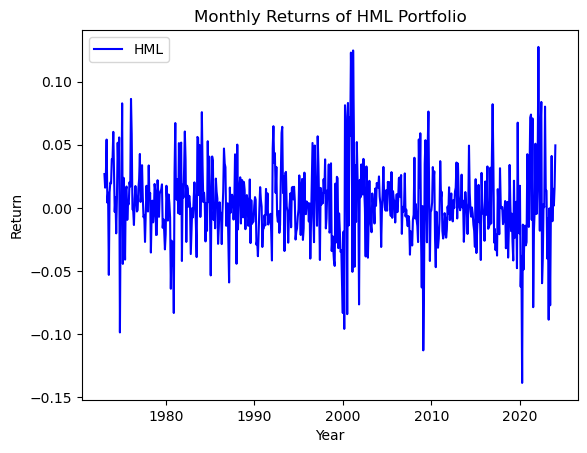

In [135]:
# Create the plot
plt.plot(french['date'], french['HML'], color='b', label='HML')

# Add titles and labels
plt.title('Monthly Returns of HML Portfolio')
plt.xlabel('Year')
plt.ylabel('Return')

# Add a legend
plt.legend()

# Show the plot
plt.show()

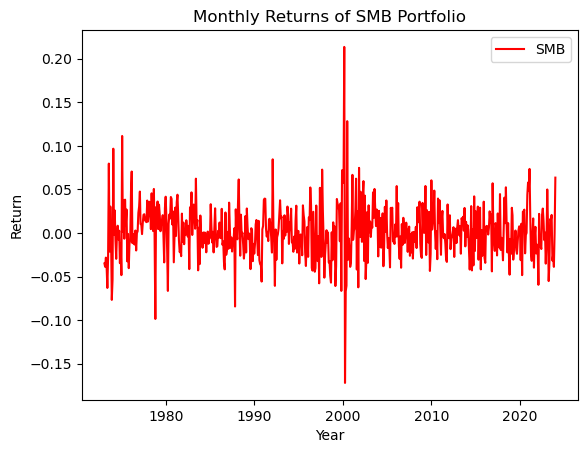

In [136]:
# Create the plot
plt.plot(french['date'], french['SMB'], color='r', label='SMB')

# Add titles and labels
plt.title('Monthly Returns of SMB Portfolio')
plt.xlabel('Year')
plt.ylabel('Return')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Something we can tell by examining these graphs is that the HML and SMB portfolios have varying volatility. We also can see the returns are inconsistent after examining many different time periods. This is likely due to the fact that the market switches between value and growth. Certain periods of time tend to favor one over the other. This can lead to overvaluation that eventually leads a mean reversion. So while these factors may not be the best to invest on, they give us interesting insights on the market value and growth dynamics. I think a good trading strategy in the future would be measuring this return and figuring out when the market tends to switch between these two factors. If we could find a trend, that could help us get more consistency than these factors alone can provide.

# Compare and contrast using the characteristic portfolios (Fama and French 1992) and the factor portfolios (Fama and French 1993).

Characteristic portfolios (formed on market equity and book to market) are used to determine the relationship between firm-specific characteristics and stock returns. It also helps test the validity of the Capital Asset Pricing Model (CAPM), which primarily uses market beta to explain stock returns.

The 1993 Fama and French paper expanded this and introduced the three-factor model thought to be more comprehensive than CAPM. This is the HML and SMB returns we created. They are important because these are not captured by market beta alone.

Both of these approaches aim to understand the determinants of stock returns and use sorting mechanisms to form portfolios based on size and book-to-market ratios. Both are empirical methods derived from observed market data and characteristics of firms.

Characteristic portfolios focus on how specific firm characteristics impact returns, while factor portfolios aim to identify broad risk factors that affect returns and require building a long-short portfolio. Characteristic portfolios primarily test the relationship between firm characteristics and returns. Factor portfolios are used to build a multi-factor model that explains stock returns more comprehensively.

Both characteristic and factor portfolios significantly contributed to financial economics by highlighting the shortfalls of the CAPM and introducing new revelations about stock returns. Characteristic portfolios provide insight into the role of firm-specific traits, while factor portfolios identify systematic risk factors. The return table we saw above help to summarize these risks and shortfalls of CAPM.

As we showed in the previous problem, the markets returns are very dynamic and cannot be explained with one economic model. The characteric portfolios and factor portfolios give us valuable insight into the movement of the market and help describe general trends of specific time periods.